In [1085]:
import sys
sys.path.append('../')
import datetime
import pandas as pd
import numpy as np
from lib import get_data
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import backend

from tensorflow.keras import Model, Sequential
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Input, SimpleRNN, Dense, GRU, Dropout, Bidirectional,\
                                    BatchNormalization, LSTM, LeakyReLU, Concatenate, GaussianNoise,\
                                    TimeDistributed
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split

print(tf.keras.__version__)
print(tf.__version__)

2.2.4-tf
2.1.0


RNN model is specifically designed for time series data, and has been shown to work well on influenza prediction as well. For example, Dr. Santillana has shown a successful Influenza RNN model in "Towards the Use of Neural Networks for Influenza Prediction at Multiple Spatial Resolutions”. In this section, We explored Recurrent Neural Network (RNN) to predict COVDI-19 cases at a given date in a given county, using previous 7 days data. 

We first read the data and normalize some of the features.


In [14]:
processed_path = '../data/processed/time_series_updated.csv'
data = pd.read_csv(processed_path)

In [867]:
# normalize 
income_max = data['income_2018'].max()
income_min = data['income_2018'].min()
data['income_2018'] = (data['income_2018'] - income_min) / income_max

pop_max = data['pop_2018'].max()
pop_min = data['pop_2018'].min()
data['pop_2018'] = (data['pop_2018']-pop_min)/pop_max


To train the RNN model, we also used the same get_model_data helper function to generate the training data, with some modifications. Instead of taking the average of all the features in the previous 7 days, we simply treat them as time series data and return them (X). Additionally, instead of taking the delta cases in the next 3 days, we simply take the the cumulative cases in the 8th day as the (y). This new get data helper function is shown in ```get_model_data_cumulative()```. Since the number of features returned from the Weather API is huge, we selected some important features based on the GLM to ease the training, as shown in the cell below.

In [900]:
OTHERS = ['date', 'county', 'state', 'fips', 'cases', 'deaths', 
                'income_2018', 'pop_2018', 'pred_days_since_10_cases',
                'pred_cases', 'pred_deaths']
WEATHER = ['heatIndexMin', 'heatIndexAvg', 'heatIndexMax','relHumMin',
                'relHumAvg', 'relHumMax',  'tempMin', 'tempAvg', 'tempMax', 'windChillMin', 'windChillAvg',
                'windChillMax', 'windDirAvg']
MOBILITY = ['retail_and_recreation_percent_change_from_baseline',
                'residential_percent_change_from_baseline',
                'workplaces_percent_change_from_baseline',
                'transit_stations_percent_change_from_baseline',
                'grocery_and_pharmacy_percent_change_from_baseline',
                'parks_percent_change_from_baseline']
COLUMNS = OTHERS + WEATHER + MOBILITY
LEN = 6

In [868]:
def get_model_data_cumulative(data, date_range=(0, 14), pred_day=21):
    """

    :param date_range: integer measuring the number of days since first day w/ 10 cases
    :param pred_day:
    :return:
    """

    # ensure full coverage of interested dates
    data = data[data['fips'].isin(data[data['days_since_10_cases'] == pred_day]['fips'].drop_duplicates())]

    # filter for training and testing dates
    data_x = data[data['days_since_10_cases'].between(date_range[0], date_range[1])]
    data_grouped = data_x.groupby(['state', 'county', 'fips']).agg('mean').reset_index()  # todo play with granularity
    data_x = data_x.drop(['days_since_10_cases'], axis=1)

    # get change rate since last training date
    data_y = data[data['days_since_10_cases'].isin([date_range[1], pred_day])][
        ['fips', 'cases', 'deaths', 'days_since_10_cases']]
    data_y = data_y.sort_values(['fips', 'days_since_10_cases']).reset_index(drop=True)
    day_idx = np.where(data_y['days_since_10_cases'] == pred_day)[0]
    data_y_new = data_y.iloc[day_idx, :].reset_index()
    data_y_new = data_y_new.drop(['index'], axis=1)
    data_y_new['fips'] = data_y.loc[day_idx, 'fips'].reset_index(drop=True)
    data_y_new = data_y_new.add_prefix('pred_')
    
    
    data = data_x.merge(data_y_new, left_on='fips', right_on='pred_fips', how='inner')
#     data_grouped = data_grouped.merge(data_y, left_on='fips', right_on=f'day_{pred_day}_cumulative_fips',
#                                       how='inner')
#     data_grouped = data_grouped.drop(f'day_{pred_day}_cumulative_fips', axis=1)
    data = data.drop('pred_fips', axis=1)
    
    data = data[COLUMNS]
    data = data.fillna(0)
    data = data.drop(['county','state'],axis=1)
#     data_grouped = data_grouped[COLUMNS]
    return data 


### Generating the training set


Since we are still in the middle of this pandemic, the data related to COVID-19 is still very limited. Instead of just generating 1 unit of time series data for each county (the whole timeline of the county), we break the timeline of each county (from Jan. to late April) into 7-day chunks using in a rolling basis starting from the day of reaching 10 cases, as described above. This way helps us to generate more training data to train the RNN model. 

In [901]:


def generate_rnn_data(start, end, LEN, data):

    for i in range(start, end):
        df = get_model_data_cumulative(data, date_range=(i, i+LEN), pred_day=i+LEN+1)
        if df.empty is False:
            grouped_by_fips = df.groupby(['fips']).groups
            count = 0
            for fips in grouped_by_fips:
                index = grouped_by_fips[fips]
                y = np.expand_dims(df.iloc[index]['pred_cases'].to_numpy(),axis=0)
                features = df.iloc[index].drop(['pop_2018','income_2018','pred_cases','pred_deaths'],axis=1)
    #             train = np.expand_dims(df.iloc[index][['cases']].to_numpy(),axi,s=0)
    #             train = np.expand_dims(df.iloc[index].drop(['date','fips'],axis=1)[['cases','pred_cases']].to_numpy(),axis=0)
                statis_features = df.iloc[index][['pop_2018','income_2018']]

                if i == 1:
                    X_time_series = np.expand_dims(features.to_numpy(),axis=0)
                    time_series_col = features.columns
                    X_static = np.expand_dims(statis_features.iloc[0].to_numpy(),axis=0)
                    static_series_col = statis_features.columns
    #                 X_train = train[:,:,0]
                    y_true = y.mean()
    #                 y_train = train[:,:,1].mean()
                else:
                    X_time_series = np.vstack((X_time_series,  np.expand_dims(features.to_numpy(),axis=0)))
                    X_static = np.vstack((X_static,  np.expand_dims(statis_features.iloc[0].to_numpy(),axis=0)))
                    y_true =np.vstack((y_true, y.mean()))
    return X_time_series, X_static, y_true, time_series_col, static_series_col


In [551]:
start = 1
end = 100
X_time_series, X_static, y_true, time_series_col, static_series_col = generate_rnn_data(start, end, LEN, data)

An example of the training set. There are 7 rows, representing 7 days of previous data (X), the ```pred_cases``` column is the y. Columns ```income_2018``` and ```pop_2018``` will be treated as static features - they will be fed as a separate input to the model. Columns such as ```date``` and ```fips``` are for display only, and will be dropped during training.

In [1047]:
get_model_data_cumulative(data, date_range=(0, 0+LEN), pred_day=0+LEN+1)[:7]

,date,fips,cases,deaths,income_2018,pop_2018,pred_days_since_10_cases,pred_cases,pred_deaths,heatIndexMin,...,windChillMin,windChillAvg,windChillMax,windDirAvg,retail_and_recreation_percent_change_from_baseline,residential_percent_change_from_baseline,workplaces_percent_change_from_baseline,transit_stations_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline
0,2020-03-05,53061,17,0,0.151492,0.080376,7,107,3,0.563973,...,0.721679,0.667834,0.564639,0.511111,1.0,4.0,-7.0,-8.0,7.0,23.0
1,2020-03-06,53061,18,0,0.151492,0.080376,7,107,3,0.554994,...,0.713121,0.628160,0.463942,0.386111,-3.0,5.0,-9.0,-11.0,2.0,6.0
2,2020-03-07,53061,26,0,0.151492,0.080376,7,107,3,0.537037,...,0.699674,0.608324,0.452974,0.530556,-6.0,2.0,-2.0,-5.0,-2.0,26.0
3,2020-03-08,53061,36,0,0.151492,0.080376,7,107,3,0.502245,...,0.654442,0.601322,0.476903,0.966667,4.0,2.0,-4.0,0.0,-4.0,30.0
4,2020-03-09,53061,45,0,0.151492,0.080376,7,107,3,0.465208,...,0.620212,0.597822,0.524759,0.041667,0.0,4.0,-6.0,-9.0,2.0,50.0
5,2020-03-10,53061,61,0,0.151492,0.080376,7,107,3,0.503367,...,0.654442,0.635161,0.499834,0.497222,0.0,6.0,-14.0,-15.0,3.0,23.0
6,2020-03-11,53061,69,1,0.151492,0.080376,7,107,3,0.576319,...,0.726569,0.669000,0.531738,0.900000,2.0,6.0,-13.0,-14.0,8.0,69.0


In [ ]:
# np.save('../data/rnn_data/X_time_series.npy',X_time_series,allow_pickle)
# np.save('../data/rnn_data/X_static.npy',X_static)
# np.save('../data/rnn_data/y_true.npy',y_true)

### Split train_test


In [1041]:
X_time_series = np.load('../data/rnn_data/X_time_series.npy',allow_pickle=True)
X_static = np.load('../data/rnn_data/X_static.npy',allow_pickle=True)
y_true = np.load('../data/rnn_data/y_true.npy',allow_pickle=True)

In [1042]:
X_time_series_data = X_time_series[:,:,2:].astype(np.float32)
fips_date = X_time_series[:,:,:2]

X_time_series_train, X_time_series_test, X_static_train, \
    X_static_test, y_train, y_test, fips_date_train, fips_date_test = train_test_split(X_time_series_data, X_static, y_true, fips_date, test_size=0.1, random_state=109)


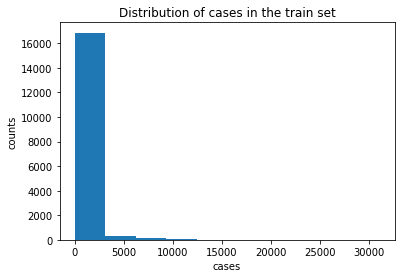

In [1043]:
plt.hist(y_train)
plt.xlabel('cases')
plt.ylabel('counts');
plt.title('Distribution of cases in the train set');

### Upsampling
As shown by the histogram above, the distribution of COVID-19 cases are largely skewed to the right. Most of the counties, at most, have less than 5000 of cases. Thus, we decided to upsample counties with a large amount of cases at different rates, with some noises added sampled from the Gaussian distribution. It helps alleviate the data imbalance problem, and also boost the training size.

In [1044]:
def upsampling(x1, x2, y, threshold1,threshold2, rate):
    idx = np.where((y > threshold1) & (y < threshold2))[0]
    y_resample = np.tile(y[idx], (rate,1))
    noise = np.random.normal(0,10,y_resample.shape) 
    y_new = np.append(y,y_resample+noise,axis=0)
    
    
    X_time_series_resample = np.tile(x1[idx],(rate,1,1))
    x1_new = np.append(x1, X_time_series_resample,axis=0)

    X_static_resample = np.tile(x2[idx],(rate,1))
    x2_new = np.append(x2, X_static_resample,axis=0)
    
    return x1_new, x2_new, y_new

In [1045]:
X_time_series_train, X_static_train, y_train = upsampling(X_time_series_train, X_static_train, y_train, 5000, 10000, 150)
X_time_series_train, X_static_train, y_train = upsampling(X_time_series_train, X_static_train, y_train, 10000, 20000, 500)
X_time_series_train, X_static_train, y_train = upsampling(X_time_series_train, X_static_train, y_train, 20000, 30000, 1500)
X_time_series_train, X_static_train, y_train = upsampling(X_time_series_train, X_static_train, y_train, 30000, 40000, 5000)

The histogram here shows the distribution after upsampling.

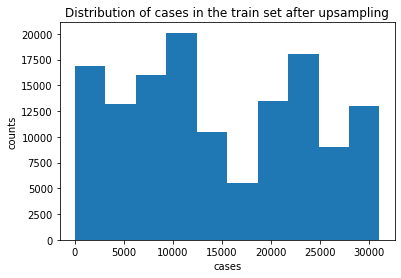

In [1046]:
plt.hist(y_train)
plt.xlabel('cases')
plt.ylabel('counts');
plt.title('Distribution of cases in the train set after upsampling');

The final training set has 136231 samples. Each sample has 7 time series data points, and each time series point has 22 features including previous COVID-19 cases, weather and mobility.

In [1028]:
X_time_series_train.shape

(136231, 7, 22)

### Baseline RNN

We first built a baseline RNN model using just the previous 7-day cases as the input data. (features such as weather and mobility are excluded). Now the input array has shape (None, 7, 1). 

We specifically add Gaussian noise to the input to introduce more variability to the data.

The model architecture is shown below. The loss here is ```MeanSquaredLogarithmicError()``` (MSLE). MSLE will treat small differences between small true and predicted values approximately the same as big differences between large true and predicted values. Thus, a prediction of 10 when the true value is 100 will produce the same loss as a prediction of 3000 when the true value is 30000. In this learning scenario, we care about the relative difference between the true and the predicted value than the absolute difference.


In [1103]:
X_time_series_train_base = np.expand_dims(X_time_series_train[:,:,0],axis=2)
X_time_series_test_base = np.expand_dims(X_time_series_test[:,:,0],axis=2)

In [1104]:
# time series input
time_series_input = Input(shape=(7,1), name='time_series_input')
noise_layer1 = GaussianNoise(0.1)(time_series_input)
rnn1 = LSTM(64, return_sequences=False, recurrent_dropout=0.2)(noise_layer1)

dense = Dense(32)(rnn1)
dropout = Dropout(0.3)(dense)
output = Dense(1, activation='relu',name="output")(dropout)


baseline = Model(time_series_input, output, name='baseline')

baseline.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredLogarithmicError())
baseline.summary()

Model: "baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_series_input (InputLaye [(None, 7, 1)]            0         
_________________________________________________________________
gaussian_noise_32 (GaussianN (None, 7, 1)              0         
_________________________________________________________________
lstm_93 (LSTM)               (None, 64)                16896     
_________________________________________________________________
dense_96 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_84 (Dropout)         (None, 32)                0         
_________________________________________________________________
output (Dense)               (None, 1)                 33        
Total params: 19,009
Trainable params: 19,009
Non-trainable params: 0
______________________________________________________

The model is trained for max 300 epochs with batch size of 1024. ```ReduceLROnPlateau()``` is used to slow the learning rate when loss starts to plateau. We also use ```EarlyStopping()``` to finish training early when the loss stops to decrease.

In [1105]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1, factor=0.6),
             EarlyStopping(monitor='val_loss', patience=10),
             ModelCheckpoint(filepath='../../models/baseline.h5', monitor='val_loss', save_best_only=True)]
history_baseline = baseline.fit(X_time_series_train_base, y_train, batch_size=1024, epochs=300, 
                    validation_split=0.1, verbose=1, shuffle=True,  callbacks=callbacks)

Train on 122157 samples, validate on 13574 samples
Epoch 1/300
122157/122157 [==============================] - 4s 32us/sample - loss: 45.2478 - val_loss: 42.6849
Epoch 2/300
122157/122157 [==============================] - 2s 19us/sample - loss: 25.0486 - val_loss: 33.2190
Epoch 3/300
122157/122157 [==============================] - 2s 19us/sample - loss: 20.0353 - val_loss: 28.4391
Epoch 4/300
122157/122157 [==============================] - 2s 19us/sample - loss: 17.0537 - val_loss: 25.1142
Epoch 5/300
122157/122157 [==============================] - 2s 19us/sample - loss: 14.9104 - val_loss: 22.6010
Epoch 6/300
122157/122157 [==============================] - 2s 19us/sample - loss: 13.2790 - val_loss: 20.6056
Epoch 7/300
122157/122157 [==============================] - 2s 18us/sample - loss: 11.9705 - val_loss: 18.9652
Epoch 8/300
122157/122157 [==============================] - 2s 19us/sample - loss: 10.9023 - val_loss: 17.5813
Epoch 9/300
122157/122157 [==========================

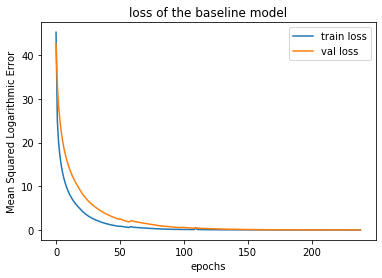

In [1110]:
plt.plot(history_baseline.history['loss'], label='train loss')
plt.plot(history_baseline.history['val_loss'],label='val loss')
plt.legend()
plt.title('loss of the baseline model')
plt.xlabel('epochs')
plt.ylabel('Mean Squared Logarithmic Error');

The baseline model does a well job here in terms of loss. There is no overfitting and it produced a very low loss on a separate testing set.

In [1107]:
baseline.evaluate(X_time_series_test_base, y_test)

1932/1932 [==============================] - 0s 46us/sample - loss: 0.0077


0.007711621232747291

### Case Studies (Baseline)
Here we demonstrate how the baseline model predicts the cases in some counties. The predictions are very reasonable for these counties except the last one - it seems like the prediction is capped around 24,000 cases. One reason might be that the model still does still see enough training samples with large case numbers. 

In [1101]:
def predict_cases(fips, model, data, baseline=True):
    index = (data['fips'] == fips)
    county = data.iloc[np.where(index)[0][0]]['county']
    state = data.iloc[np.where(index)[0][0]]['state']
    
    county_data = data[(data['fips'] == fips)]
    county_X_time_series_raw, county_X_static, county_y_true, county_time_series_col, county_static_series_col  = genrate_rnn_data(start, end, LEN, county_data)
    county_X_time_series = county_X_time_series_raw[:,:,2:].astype(np.float32)
    date = np.array([pd.to_datetime(row[0][0]) for row in county_X_time_series_raw])
    index = sorted(range(len(date)), key=lambda k: date[k])
    
    date_new = date[index]
    county_X_time_series = county_X_time_series[index]
    county_X_static = county_X_static[index]
    county_y_true = county_y_true[index]
    
    if baseline:
        county_X_time_series = np.expand_dims(county_X_time_series[:,:,0],axis=2)
        predict_test = model.predict(county_X_time_series)
    else:
        predict_test = model.predict([county_X_time_series, county_X_static])
    plt.scatter(range(len(date_new)), predict_test, label='predicted cases')
    plt.scatter(range(len(date_new)),county_y_true, label='true cases')
    plt.xlabel('day since first 10 cases')
    plt.ylabel('cases')
    plt.legend()
    plt.title('Cases for {}, {}'.format(county, state))

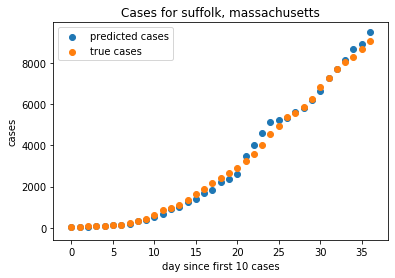

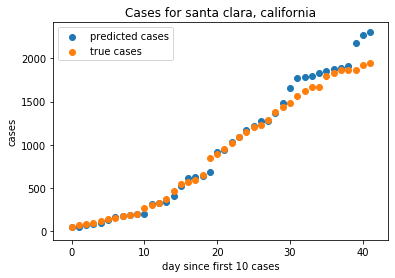

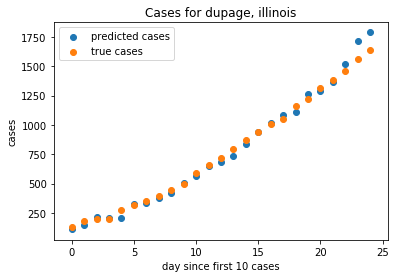

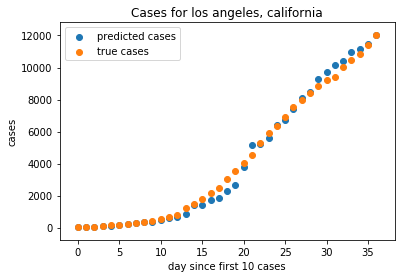

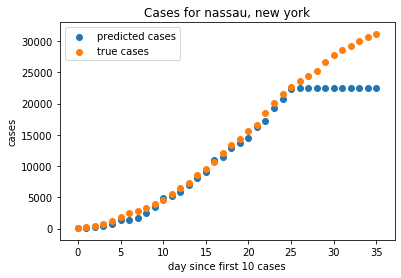

In [1084]:
predict_cases(25025, model, data)
plt.show()
predict_cases(6085, model, data)
plt.show()
predict_cases(17043, model, data)
plt.show()
predict_cases(6037, model, data)
plt.show()
predict_cases(36059, model, data)

### RNN with all features

Here we incorporate all available features to train the RNN model. The input shape is (None, 7, 22).

We have two inputs here feeding into the data, one being the time series data (cases, mobility, weather) and one being the static features (population, income). We concatenate them after the LSTM layer.

In [1106]:
# time series input
time_series_input = Input(shape=(7,22), name='time_series_input')
noise_layer1 = GaussianNoise(0.1)(time_series_input)
rnn1 = LSTM(64, return_sequences=True, recurrent_dropout=0.2)(noise_layer1)
rnn2 = LSTM(32)(rnn1)

#static input branch
static_input_layer = Input(shape=(2))
noise_layer2 = GaussianNoise(0.1)(static_input_layer)
static_dense = Dense(64)(noise_layer2)
static_dropout = Dropout(0.3)(static_dense)

concat = Concatenate(axis=-1)([rnn2,static_dropout])
dense = Dense(32)(concat)
dropout = Dropout(0.3)(dense)
output = Dense(1, activation='relu',name="output")(dropout)


model = Model([time_series_input,static_input_layer ], output, name='rnn')

model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredLogarithmicError())

In [1092]:
model.summary()

Model: "rnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
time_series_input (InputLayer)  [(None, 7, 22)]      0                                            
__________________________________________________________________________________________________
gaussian_noise_29 (GaussianNois (None, 7, 22)        0           time_series_input[0][0]          
__________________________________________________________________________________________________
input_39 (InputLayer)           [(None, 2)]          0                                            
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 7, 32)        736         gaussian_noise_29[0][0]          
________________________________________________________________________________________________

In [1093]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1, factor=0.6),
             EarlyStopping(monitor='val_loss', patience=20),
             ModelCheckpoint(filepath='../../models/best_model_3.h5', monitor='val_loss', save_best_only=True)]

In [1094]:
history1 = test.fit([X_time_series_train, X_static_train], y_train, batch_size=1024, epochs=300, 
                    validation_split=0.1, verbose=1, shuffle=True,  callbacks=callbacks)

Train on 122157 samples, validate on 13574 samples
Epoch 1/300
122157/122157 [==============================] - 7s 59us/sample - loss: 41.1276 - val_loss: 42.7676
Epoch 2/300
122157/122157 [==============================] - 4s 32us/sample - loss: 25.3429 - val_loss: 33.0315
Epoch 3/300
122157/122157 [==============================] - 4s 32us/sample - loss: 19.3367 - val_loss: 26.6053
Epoch 4/300
122157/122157 [==============================] - 4s 32us/sample - loss: 15.3097 - val_loss: 22.0461
Epoch 5/300
122157/122157 [==============================] - 4s 32us/sample - loss: 12.4861 - val_loss: 18.6927
Epoch 6/300
122157/122157 [==============================] - 4s 32us/sample - loss: 10.4378 - val_loss: 16.1324
Epoch 7/300
122157/122157 [==============================] - 4s 32us/sample - loss: 8.8956 - val_loss: 14.1270
Epoch 8/300
122157/122157 [==============================] - 4s 32us/sample - loss: 7.7334 - val_loss: 12.5301
Epoch 9/300
122157/122157 [============================

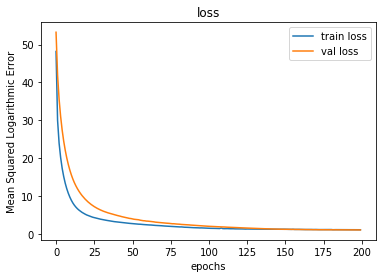

In [849]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'],label='val loss')
plt.legend()
plt.title('loss')
plt.xlabel('epochs')
plt.ylabel('Mean Squared Logarithmic Error');

In [1033]:
pred = model.predict([X_time_series_test, X_static_test])
model.evaluate([X_time_series_test, X_static_test], y_test)

1932/1932 [==============================] - 0s 51us/sample - loss: 3.4490


3.4489613398755314

### Case studies (RNN with all features)

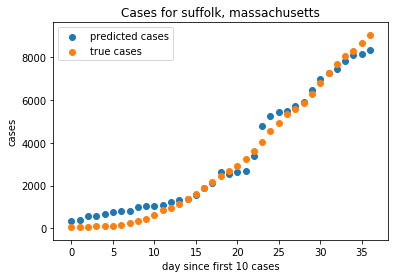

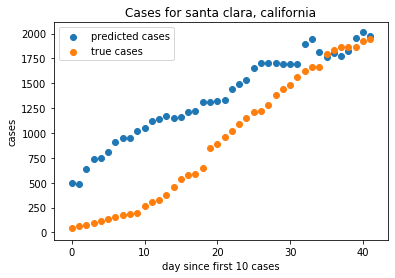

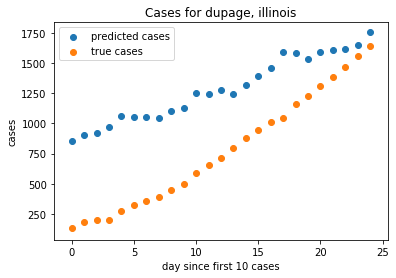

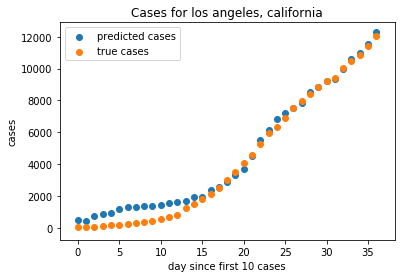

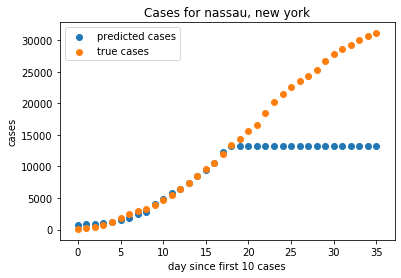

In [1034]:
predict_cases(25025, model, data)
plt.show()
predict_cases(6085, model, data)
plt.show()
predict_cases(17043, model, data)
plt.show()
predict_cases(6037, model, data)
plt.show()
predict_cases(36059, model, data)


Unexpectedly, the baseline model actually out-performs the more complex model, in terms of loss and actual case prediction. The complex model tends to overestimate the cases, and also is capped at a lower number, around 15,000 cases. 

Intuitively, mobility and weather data would help the model to learn better as they are directly related to how the virus is spreading in a county.

There are couple reasons why these features are not helping:

    1. The dataset only span 3 months. The weather is unlikely to change dramatically and thus it has little impact on the model.
    2. The mobility data are not standardized. Since the range of the mobility data is not wide, we decide not to standardized them. However, later we find out that the same number doesn't necessarily mean the same amount of movement in different counties - all the movements are relative to its own county baseline. Thus, it is not appropriate to just feed these data into the model without doing any feature engineering. This is an example of dataset shift and we need to find a transformation function to put the mobility data from different counties on to the same scale.
